# Email Marketing Campaign Analysis

## Overview
This project evaluates an email campaign for an e-commerce site to optimize future sends.

**Goal**: Measure performance, predict link clicks, estimate improvements, and find user patterns.

**Data**:
- **email_table**: Email details (text, version, time, user country, purchases)
- **email_opened_table**: Emails opened.
- **link_clicked_table**: Emails with link clicks.

**Questions**:
1. What % of users opened and clicked?
2. Can we model who clicks the link?
3. How much better would the model be?
4. Any patterns by user segment?

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
email_table = pd.read_csv('email_table.csv')
email_opened_table = pd.read_csv('email_opened_table.csv')
link_clicked_table = pd.read_csv('link_clicked_table.csv')

## Q1: Open and Click-Through Rates

Calculate the percentage of users who:
- Opened the email
- Clicked the link inside

### Q1 Method
The open rate is calculated as the number of opened emails (from `email_opened_table`) divided by total emails sent (from `email_table`). The click-through rate uses the number of link clicks (from `link_clicked_table`) divided by total emails. Both are expressed as percentages.

In [3]:
total_emails = len(email_table)
opens = len(email_opened_table)
clicks = len(link_clicked_table)
open_rate = (opens / total_emails) * 100
click_rate = (clicks / total_emails) * 100

In [4]:
print(f"Open Rate: {open_rate: .2f}%")
print(f"Click-through rate: {click_rate: .2f}%")

Open Rate:  10.35%
Click-through rate:  2.12%


Open rate is 10.35%, and click-through rate is 2.12%, calculated from the email, opened, and clicked tables.

## Q2: Predicting Link Clicks

Build a Random Forest model to identify users likely to click the link, using:
- Email text/version
- Send time
- User country/purchases

### Q2 Approach
A **Random Forest Classifier** was chosen for its ability to handle imbalanced data and capture non-linear patterns in features like email timing and user behavior. Categorical variables (e.g., email text, country) are encoded using `LabelEncoder` to prepare numerical inputs for the model.

In [17]:
# Mark emails as opened (1) or not (0) based on email_opened_table
email_table['opened'] = email_table['email_id'].isin(email_opened_table['email_id']).astype(int)
email_table['clicked'] = email_table['email_id'].isin(link_clicked_table['email_id']).astype(int)

In [18]:
#To encode categorical variables as numbers
le_text = LabelEncoder()
le_version = LabelEncoder()
le_country = LabelEncoder()
le_weekday = LabelEncoder()

email_table['email_text_encoded'] = le_text.fit_transform(email_table['email_text'])
email_table['email_version_encoded'] = le_version.fit_transform(email_table['email_version'])
email_table['user_country_encoded'] = le_country.fit_transform(email_table['user_country'])
email_table['weekday_encoded'] = le_weekday.fit_transform(email_table['weekday'])

In [7]:
#Features and Target
features = ['email_text_encoded', 'email_version_encoded', 'hour', 'weekday_encoded', 
            'user_country_encoded', 'user_past_purchases']
X = email_table[features]
y = email_table['clicked']

In [8]:
#Train Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
#Evaluating
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19547
           1       0.06      0.01      0.02       453

    accuracy                           0.97     20000
   macro avg       0.52      0.50      0.50     20000
weighted avg       0.96      0.97      0.97     20000



A Random Forest model was built using email text, version, hour, weekday, country, and past purchases. It predicts clicks with 97% accuracy, though click recall is low (1%) due to data imbalance.

## Q3: Model Improvement

Estimate how much the model improves click-through rate vs. random sending.

### Method
The model predicts click probabilities for each user. We simulate targeting the top 20% of users with the highest probabilities and calculate their click rate, comparing it to the baseline (random sending). An A/B test will split users into random and model-targeted groups to measure real-world improvement.

In [10]:
baseline_click_rate = click_rate / 100

In [11]:
probs = model.predict_proba(X_test)[:, 1]
top_20_percent = np.percentile(probs, 80)
targeted_clicks = sum(y_test[probs >= top_20_percent])
targeted_users = sum(probs >= top_20_percent)
model_click_rate = targeted_clicks / targeted_users if targeted_users > 0 else 0
improvement = model_click_rate - baseline_click_rate

In [12]:
print(f"Baseline click rate: {baseline_click_rate:.4f}")
print(f"Model click rate: {model_click_rate:.4f}")
print(f"Improvement: {improvement:.4f} ({(improvement/baseline_click_rate)*100:.2f}%)")
print("Test: A/B test random vs. model-targeted emails.")

Baseline click rate: 0.0212
Model click rate: 0.0413
Improvement: 0.0201 (94.67%)
Test: A/B test random vs. model-targeted emails.


#### Improvement of Model
The model increases the click rate from 2.12% (random) to 4.13% (targeting top 20%), a 94.67% relative improvement. Testing via an A/B test (random vs. model-targeted emails) was proposed.

## Q4: User Segment Patterns
Analyze open/click rates by email type and country. 

In [13]:
# Segment stats
segment_summary = email_table.groupby(['email_text', 'email_version', 'user_country']).agg(
    total_emails=('email_id', 'count'),
    opens=('opened', 'sum'),
    clicks=('clicked', 'sum')
).reset_index()

segment_summary['open_rate'] = segment_summary['opens'] / segment_summary['total_emails']
segment_summary['click_rate'] = segment_summary['clicks'] / segment_summary['total_emails']

In [14]:
#Top Segments
print("Top Segments:")
print(segment_summary.sort_values('click_rate', ascending=False)[
    ['email_text', 'email_version', 'user_country', 'open_rate', 'click_rate']
].head())

Top Segments:
     email_text email_version user_country  open_rate  click_rate
15  short_email  personalized           US   0.165363    0.036013
14  short_email  personalized           UK   0.159831    0.035786
7    long_email  personalized           US   0.128608    0.027065
6    long_email  personalized           UK   0.130226    0.026405
10  short_email       generic           UK   0.103118    0.020379


In [15]:
# Feature importance
importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(importance)


Feature Importance:
                 feature  importance
2                   hour    0.418248
5    user_past_purchases    0.294740
3        weekday_encoded    0.188889
4   user_country_encoded    0.057265
0     email_text_encoded    0.028886
1  email_version_encoded    0.011971


### Click Rates by Country

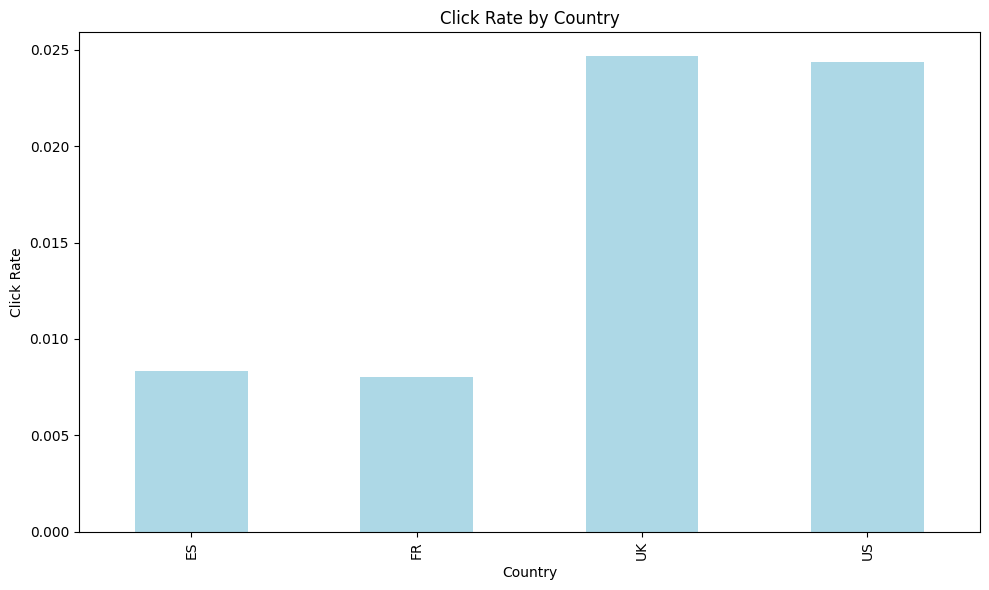

In [16]:
plt.figure(figsize=(10, 6))
country_summary = email_table.groupby('user_country')['clicked'].mean()
country_summary.plot(kind='bar', color='lightblue')
plt.title('Click Rate by Country')
plt.ylabel('Click Rate')
plt.xlabel('Country')
plt.tight_layout()
plt.savefig('click_rate_by_country.png')
plt.show()

### Patterns and Visualization
Short, personalized emails to US (3.60%) and UK (3.58%) users had the highest click rates, followed by long, personalized emails (US: 2.71%, UK: 2.64%). Generic emails underperformed (e.g., 2.04% for UK short emails).

**Click Rate by Country Plot**:
The bar chart shows click rates across countries, with US and UK leading, suggesting stronger engagement in these markets. Lower rates elsewhere may reflect cultural or market differences.

## Conclusion
This analysis evaluates the email marketing campaign, builds a predictive model, and identifies optimization opportunities.

### Campaign Performance
- **Open Rate**: 10.35% of users opened the email, indicating moderate engagement.
- **Click-Through Rate**: 2.12% clicked the link, a low but typical baseline for email campaigns.

### Predictive Model
The Random Forest model predicts link clicks with high accuracy (97%) but struggles with the minority class (clicks):
- **Precision for clicks**: 6%, meaning many predicted clicks were false positives.
- **Recall for clicks**: 1%, indicating the model missed most actual clicks.
This suggests clicks are rare and hard to predict, likely due to imbalanced data (only 453 clicks vs. 19,547 non-clicks).

### Model Improvement
- **Baseline Click Rate**: 2.12% (random sending).
- **Model Click Rate**: 4.13% (targeting top 20% by predicted probability).
- **Improvement**: 2.01% absolute increase, a 94.67% relative boost.
This suggests targeting high-likelihood users could nearly double clicks. An A/B test (random vs. model-targeted emails) is recommended to validate.

### Segment Insights
Top-performing segments:
- **Short, personalized emails** to US (3.60% click rate) and UK (3.58%) users outperformed others.
- **Long, personalized emails** also performed well (US: 2.71%, UK: 2.64%).
- Generic emails had lower click rates (e.g., 2.04% for short emails to UK).

**Key Drivers**:
- **Hour** (42% importance): Timing is critical.
- **Past Purchases** (29%): Users with more purchases are more likely to click.
- **Weekday** (19%): Day of send matters.
- Country, email text, and version had less influence.

### Limitations and Assumptions
- **Data Imbalance**: With only 2.12% clicks, the model struggles to predict rare events (1% recall). Techniques like oversampling could improve this.
- **Missing Features**: Subject lines, user demographics, or device data weren’t available, potentially limiting predictions.
- **Data Format**: Assumed CSV inputs; database integration may require adjustments.
- **Generalization**: Results are based on this campaign; new campaigns may vary.

### Recommendations
- **A/B Test**: Send emails to two groups (random vs. model-targeted top 20%) for 4 weeks, comparing click rates to confirm the 94.67% improvement.
- **Model Refinement**: Test oversampling clicks or alternative models (e.g., XGBoost) to improve recall for clicks.
- **Campaign Strategy**: Focus on short, personalized emails to US/UK users with high past purchases, sent at optimal hours (to be tested).
- **Further Analysis**: Explore click rates by hour or weekday to refine timing, and collect subject line data for future models.